# ST-DBSCAN Clustering of 2019 Teil Quake Tweets
---

This code relies on the **ST-DBSCAN** algorithm, which is a spatial-temporal clustering algorithm. It is based on the DBSCAN algorithm, but with the addition of a time dimension. We have used the following implementation [ST-DBSCAN](https://github.com/eren-ck/st_dbscan). 

```bash
$ pip install st_dbscan
```

Please read the following paper for more information: [ST-DBSCAN: An algorithm for clustering spatial–temporal data](https://www.sciencedirect.com/science/article/pii/S0169023X06000218).

### Importing libraries

We use these libraries as following:
- **pandas** for data manipulation ;
- **st_dbscan** for clustering and **matplotlib** for plotting.

In [1]:
import os
import time
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from st_dbscan import ST_DBSCAN
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon
from sklearn.preprocessing import MinMaxScaler

# Set numpy print options
np.set_printoptions(suppress=True, precision=3)

# Use interactive matplotlib
%matplotlib widget

### Reading tweets dataset

Tweets are stored in a csv file. We convert these data points to *hdf* for efficient queriying.

In [2]:
# Set data directory
data_dir = os.path.realpath("../data")

# Check if tweets.h5 exists (if previously converted)
if os.path.exists(os.path.join(data_dir, "tweets.h5")):
    # Store tweets in tweets pandas dataframe
    tweets = pd.read_hdf(os.path.join(data_dir, "tweets.h5"), "tweets")
else:
    # Convert tweets to hdf format
    # ? hdf manages large data well
    tweets = pd.read_csv(os.path.join(data_dir, "tweets.csv"))
    tweets.to_hdf(os.path.join(data_dir, "tweets.h5"), "tweets")

### Preprocessing

The preprocessing is done in the following steps:
- Remove tweets with no location information ;
- Remove tweets that are not in France ;
- Convert time to pandas datetime ;
- Order tweets by datetime ;
- Remove columns that are not needed ;
- Create a new index for the data.

In [3]:
# Remove tweets with no coordinates
tweets = tweets[tweets["longitude"].notnull()]

# Constrain the area to France
tweets = tweets.loc[
    (tweets.latitude > 42.33278)
    & (tweets.latitude < 51.08917)
    & (tweets.longitude > -4.795556)
    & (tweets.longitude < 8.230556)
]

# Order tweets by datetime
tweets['createdAt'] = pd.to_datetime(tweets['createdAt'])
tweets.sort_values(by="createdAt", inplace=True)

# Remove columns that are not needed
try:
    tweets.drop(columns=['tweetId', 'mention', 'start', 'end', 'altitude', 'osm', 'geonames'], inplace=True)
except:
    pass

# Set id as index
tweets["id"] = range(1, len(tweets) + 1)
tweets.set_index('id', inplace=True, verify_integrity=False)

### Reprojecting tweets WGS → Lambert-93

Since we will be focusing on France, we will reproject the data to the Lambert Conformal Conic projection. This projection is used in France to represent the country on a flat map. We use the **geopandas** library to do this.

In [4]:
# Convert tweets to geodataframe
tweets = gpd.GeoDataFrame(tweets, geometry=gpd.points_from_xy(tweets.longitude, tweets.latitude), crs="EPSG:4326")

# Project tweets to Lambert 93
tweets = tweets.to_crs("EPSG:2154")

# Calculate projected coordinates
tweets['x_m'] = tweets.geometry.x.round(3)
tweets['y_m'] = tweets.geometry.y.round(3)

# Reorder columns
tweets = tweets[['text', 'entity', 'wikidata', 'x_m', 'y_m', 'createdAt', 'geometry']]

In [5]:
tweets.head()

,text,entity,wikidata,x_m,y_m,createdAt,geometry
id,,,,,,,
1,il y a 23 min #seisme 2.0 a frappé Arbaz (Sion...,Arbaz,Q68113,1037421.834,6583455.288,2019-11-11 09:23:24+00:00,POINT (1037421.834 6583455.288)
2,Tremblement de terre à Lyon en ce moment !!!,Lyon,Q456,843121.942,6519367.222,2019-11-11 10:53:46+00:00,POINT (843121.942 6519367.222)
3,#Séisme ressenti à #Lyon à l'instant,Lyon,Q456,843121.942,6519367.222,2019-11-11 10:53:56+00:00,POINT (843121.942 6519367.222)
4,Tremblement de terre en Ardèche à l'instant,Ardèche (département),Q3148,812290.663,6397402.763,2019-11-11 10:54:09+00:00,POINT (812290.663 6397402.763)
5,Wait ! Y’a des tremblements de terre en France...,France,Q142,624015.535,6656012.010,2019-11-11 10:54:18+00:00,POINT (624015.535 6656012.010)


### Spatial temporal clustering using ST-DBSCAN

We'll start by normalizing the data. We'll then use the ST-DBSCAN algorithm to cluster the data. We'll use the **ST_DBSCAN** library to do this.

In [6]:
# Scale coordinates to [0, 1]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(tweets[['x_m', 'y_m']])

# Convert datetime (in ns) to seconds, // (floor division) 10 ** 9 to get seconds
tweets['ts'] = tweets['createdAt'].values.astype(np.int64) // 10 ** 9
# Convert ts in tweets to cumulative seconds
tweets['ts'] = tweets['ts'] - tweets['ts'].min()

# ts, x_m_norm, y_m_norm
data = np.hstack((tweets['ts'].values.reshape(-1, 1), scaled))

# Will be used for plotting (we can't plot normalized coordinates)
COORDS = tweets.loc[:, ['x_m','y_m']].values

In [7]:
# Create a min_dist list
min_dist = [0.01 * i for i in range(1, 11)]
# Create a min_points list
min_points = [i for i in range(16, 24)]

# Calculate max number of clusters for each min_dist and min_points combination
max_n_clusters = np.zeros((len(min_points), len(min_dist)))

for i in range(len(min_dist) ):
    md = min_dist[i]
    for j in range(len(min_points)):
        mp = min_points[j]
        # Create ST-DBSCAN object
        st_dbscan = ST_DBSCAN(eps1=md, eps2=60*10, min_samples=mp, metric='euclidean', n_jobs=-1).fit(data)
        # Get number of clusters
        n_clusters = st_dbscan.labels.max() + 2
        # Store number of clusters
        max_n_clusters[j, i] = n_clusters

# Add min_dist and min_points to max_n_clusters
max_n_clusters = np.hstack((np.array(min_points).reshape(-1, 1), max_n_clusters))
max_n_clusters = np.vstack((np.array([0] + min_dist).reshape(1, -1), max_n_clusters))

# Create a dataframe from max_n_clusters
max_n_clusters = pd.DataFrame(max_n_clusters, columns=['min_points'] + [f'min_dist={i}' for i in min_dist])

# Set min_points as index
max_n_clusters.set_index('min_points', inplace=True)

# Remove first row
max_n_clusters = max_n_clusters.iloc[1:, :]

In [8]:
# Save to csv
max_n_clusters.to_csv(os.path.join(data_dir, "max_n_clusters.csv"))
max_n_clusters

,min_dist=0.01,min_dist=0.02,min_dist=0.03,min_dist=0.04,min_dist=0.05,min_dist=0.06,min_dist=0.07,min_dist=0.08,min_dist=0.09,min_dist=0.1
min_points,,,,,,,,,,
16.0,33.0,34.0,19.0,11.0,11.0,8.0,8.0,8.0,6.0,6.0
17.0,27.0,28.0,17.0,11.0,10.0,7.0,7.0,7.0,5.0,5.0
18.0,23.0,25.0,15.0,11.0,10.0,7.0,7.0,7.0,5.0,5.0
19.0,23.0,25.0,15.0,11.0,9.0,8.0,7.0,6.0,5.0,5.0
20.0,20.0,24.0,13.0,11.0,9.0,7.0,6.0,6.0,5.0,5.0
21.0,21.0,21.0,14.0,9.0,6.0,6.0,5.0,5.0,5.0,5.0
22.0,21.0,19.0,15.0,10.0,8.0,6.0,5.0,5.0,5.0,5.0
23.0,23.0,22.0,18.0,13.0,12.0,9.0,8.0,8.0,8.0,8.0


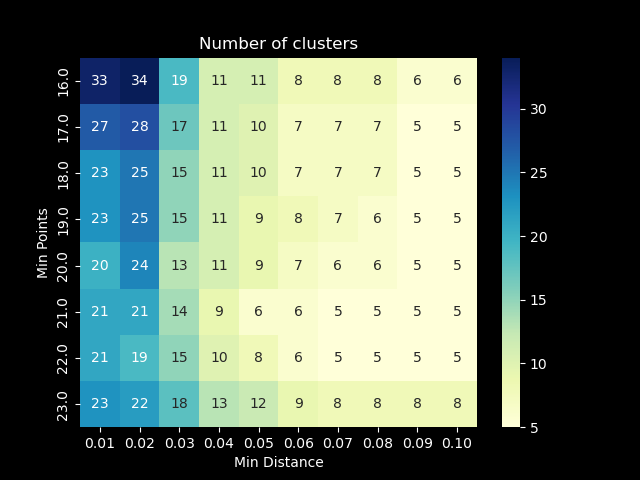

In [19]:
# Plot max_n_clusters
import seaborn as sns
fig, ax_cluster = plt.subplots()
ax_cluster = sns.heatmap(max_n_clusters, annot=True, fmt=".0f", cmap="YlGnBu", ax=ax_cluster)
ax_cluster.set_title("Number of clusters")
ax_cluster.set_xlabel("Min Distance")
ax_cluster.set_ylabel("Min Points")

# Set xlabel values
ax_cluster.set_xticklabels([f"{i:.2f}" for i in min_dist], rotation=0)

plt.show()

In [10]:
# ST-DBSCAN Clustering
# Parameters
eps1 = 0.1 # Distance threshold
eps2 = 60*10 # Time threshold
min_samples = 22 # Minimum number of tweets in a cluster

# Run ST-DBSCAN
start = time.time()
st_dbscan = ST_DBSCAN(eps1 = eps1, eps2 = eps2, min_samples = min_samples, metric = 'euclidean').fit(data)
end = time.time()

print(f"Distance: {eps1}, Time: {eps2 / 60} min, Min elements: {min_samples} tweets")
print("Time taken: ", round(end - start, 2), "s")
print("Number of clusters: {}".format(len(set(st_dbscan.labels))))

# Add cluster column to tweets
tweets['cluster'] = st_dbscan.labels

Distance: 0.1, Time: 10.0 min, Min elements: 22 tweets
Time taken:  1.84 s
Number of clusters: 5


### Create convex hull for each cluster

In order to assess the extent of the quake, we'll create a convex hull for each cluster. We'll use the **scipy.spatial** library to do this.

In [11]:
# Create a hulls geodataframe
hulls = gpd.GeoDataFrame(columns=['cluster', 'num_tweets', 'area_km2', 'start_time_ts', 'geometry'])

for cluster in set(st_dbscan.labels):
    if cluster != -1:
        # Get the coordinates of the points in the cluster
        points = COORDS[st_dbscan.labels == cluster]
        # Add start time of the cluster
        start_time = tweets[tweets['cluster'] == cluster]['ts'].min()
        # Create a convex hull
        try:
            hull = ConvexHull(points)
        except:
            continue
        # Append the cluster and hull to the geodataframe using concat instead of append
        hulls = pd.concat([hulls, gpd.GeoDataFrame({
            'cluster': [cluster],
            'num_tweets': [len(points)],
            'start_time_ts': [start_time],
            'geometry': [Polygon(points[hull.vertices])]
        })], ignore_index=True)

hulls.set_crs(epsg=2154, inplace=True)

# Calculate the area of the hulls
hulls['area_km2'] = round(hulls['geometry'].area / 1_000_000, 2)

# Clusters with no hulls
u_set = set(tweets['cluster']) - set(hulls['cluster']) - {-1}
print("Clusters with hulls: ", set(hulls['cluster']))
print("Clusters with no hulls: ", u_set)

# Remove tweet clusters with no hulls
tweets = tweets[~tweets['cluster'].isin(u_set)]

# Restart cluster ids for clusters different than -1
tweets.loc[tweets['cluster'] != -1, 'cluster'] = tweets.loc[tweets['cluster'] != -1, 'cluster'].astype('category').cat.codes

# Restart hulls cluster ids
hulls['cluster'] = hulls['cluster'].astype('category').cat.codes

# Convert start time to int
hulls['start_time_ts'] = hulls['start_time_ts'].astype(int)

Clusters with hulls:  {0, 2, 3}
Clusters with no hulls:  {1}


In [12]:
hulls.head()

,cluster,num_tweets,area_km2,start_time_ts,geometry
0,0,3644,57095.45,5422,"POLYGON ((759494.449 6278654.288, 894593.377 6..."
1,1,67,11161.97,70716,"POLYGON ((838057.960 6360621.723, 914078.319 6..."
2,2,575,24820.61,74036,"POLYGON ((914078.319 6457877.621, 843121.942 6..."


### Plot the clusters

We'll use the **matplotlib** library to plot the clusters. As a base map, we'll have a map of France. We'll use the **geopandas** library to do this.

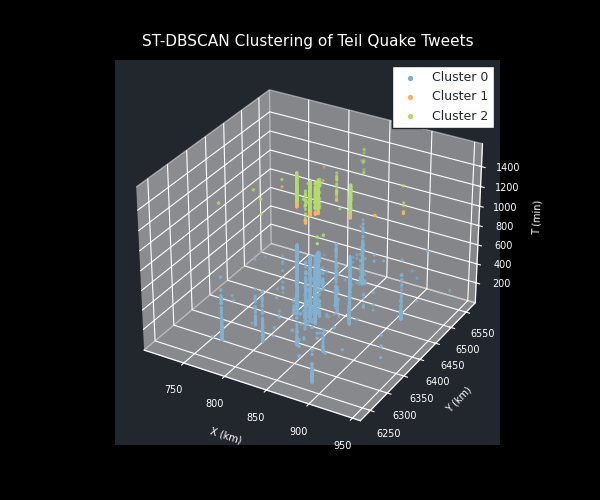

In [18]:
# Plot tweets in 3D
plt.clf()

ax_cube = plt.axes(projection='3d')
# Select tweets without noise
tweets_ = tweets[tweets['cluster'] != -1]
for cluster in set(tweets_['cluster']):
    # Select tweets in cluster
    tweets_cluster = tweets_[tweets_['cluster'] == cluster]
    # Plot tweets in cluster
    ax_cube.scatter3D(
        tweets_cluster['x_m'],
        tweets_cluster['y_m'],
        tweets_cluster['ts'] / 60,
        s=2,
        color='C{}'.format(cluster + 4),
        label='Noise' if cluster == -1 else 'Cluster {}'.format(cluster)
    )
ax_cube.set_xlabel('x_m')
ax_cube.set_ylabel('y_m')
ax_cube.set_zlabel('ts')

# Set fig size
fig = plt.gcf()
fig.set_size_inches(6, 5)

ax_cube.set_facecolor('#22272e')
ax_cube.get_figure().patch.set_facecolor('#22272e')

# Set title
ax_cube.set_title("ST-DBSCAN Clustering of Teil Quake Tweets", fontsize=11, weight='medium', color='white', pad=10)

ax_cube.legend(loc='best', fontsize=9, labelcolor='#22272e', markerscale=2,
          facecolor='white', title_fontsize=14, fancybox=False, framealpha=1, edgecolor='#22272e')

m2km = lambda x, _: f'{x/1000:g}'
ax_cube.xaxis.set_major_formatter(m2km)
ax_cube.yaxis.set_major_formatter(m2km)

# Set axis labels
ax_cube.set_xlabel("X (km)", fontsize=7, labelpad=5, color='white')
ax_cube.set_ylabel("Y (km)", fontsize=7, labelpad=5, color='white')
ax_cube.set_zlabel("T (min)", fontsize=7, labelpad=5, color='white')

# Set axis ticks color
ax_cube.tick_params(axis='x', colors='white', labelsize=7)
ax_cube.tick_params(axis='y', colors='white', labelsize=7)
ax_cube.tick_params(axis='z', colors='white', labelsize=7)

plt.show()

In [14]:
# Read France geojson
france = gpd.read_file(filename='../data/france.geojson')
france = france.to_crs("EPSG:2154")

Cluster -1: 731 tweets
Cluster 0: 3644 tweets
Cluster 1: 67 tweets
Cluster 2: 575 tweets


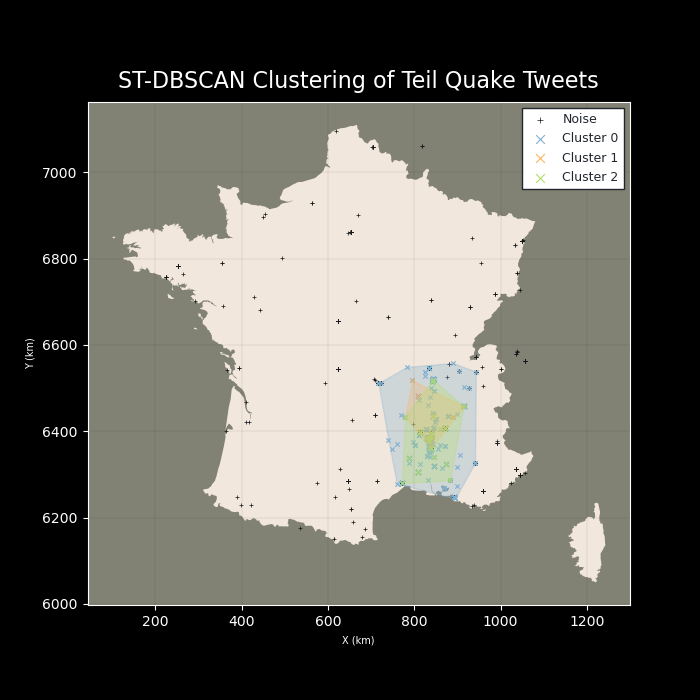

In [20]:
# Plot base map
base = france.plot(color='#F2E7DC', figsize=(7, 7), linewidth=0)
base.set_facecolor('#818274')
base.get_figure().patch.set_facecolor('#22272e')

# Plot tweets with color based on cluster
for cluster in tweets.cluster.unique():
    # Number of tweets in cluster
    num_tweets = len(tweets[tweets.cluster == cluster])
    # Check whether cluster id exists in hulls
    if cluster in hulls.cluster.values or cluster == -1:
        print("Cluster {}: {} tweets".format(cluster, num_tweets))
        tweets[tweets.cluster == cluster].plot(
            ax=base,
            markersize=6 if cluster == -1 else 10,
            label='Noise' if cluster == -1 else 'Cluster {}'.format(cluster),
            marker='x' if cluster != -1 else '+',
            color='#161819' if cluster == -1 else 'C{}'.format(cluster + 4),
            linewidth=0.5 if cluster == -1 else 0.8,
        )
    
for cluster in hulls.cluster:
    hulls[hulls.cluster == cluster].plot(
        ax=base,
        alpha=0.3,
        color='C{}'.format(cluster + 4),
        edgecolor='C{}'.format(cluster + 4),
        linewidth=1
    )

# Set title
base.set_title("ST-DBSCAN Clustering of Teil Quake Tweets", fontsize=16, weight='medium', color='white', pad=10)

# Set legend
base.legend(loc='best', fontsize=9, labelcolor='#22272e', markerscale=2, facecolor='white', title_fontsize=14, fancybox=False, framealpha=1, edgecolor='#22272e')
# bbox_to_anchor=(1.23, 1.01

# Add grid
base.grid(color='#161819', linestyle='-', linewidth=0.2, alpha=0.3)

# Change tick labels
m2km = lambda x, _: f'{x/1000:g}'
base.xaxis.set_major_formatter(m2km)
base.yaxis.set_major_formatter(m2km)

# Set axis labels
base.set_xlabel("X (km)", fontsize=7, labelpad=5, color='white')
base.set_ylabel("Y (km)", fontsize=7, labelpad=5, color='white')

# Set axis ticks color
base.tick_params(axis='x', colors='white')
base.tick_params(axis='y', colors='white')

In [21]:
# Save figures
ax.get_figure().savefig('../images/dbscan_3d.png', dpi=300, bbox_inches='tight', facecolor=ax.get_figure().get_facecolor(), edgecolor='none')
base.get_figure().savefig('../images/dbscan.png', dpi=300, bbox_inches='tight', facecolor=base.get_figure().get_facecolor(), edgecolor='none')
ax_cluster.get_figure().savefig('../images/param.png', dpi=300, bbox_inches='tight', facecolor=ax_cluster.get_figure().get_facecolor(), edgecolor='none')

In [17]:
# Export tweets to geojson
tweets.to_file('../data/tweets_stdbscan.geojson', driver='GeoJSON')

# Export hulls to geojson
hulls.to_file('../data/hulls_stdbscan.geojson', driver='GeoJSON')

> Made with ♥ by Léa, Romain and Salaheddine.